In [486]:
import etl_eda
import importlib
importlib.reload(etl_eda)
from etl_eda import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, normaltest, spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [487]:
df_train = load('train.csv')
df_item_categories = load('item_categories.csv')
df_shops = load('shops.csv')
df_items  = load('items.csv')

In [488]:
df_train[['item_cnt_month', 'item_price']].describe().map(lambda x: f"{x:0.1f}")

,item_cnt_month,item_price
count,1609122.0,1609122.0
mean,2.3,790.7
std,8.4,1532.6
min,-22.0,0.1
25%,1.0,199.0
50%,1.0,399.0
75%,2.0,898.5
max,1644.0,50999.0


ITEM_CNT_MONTH

In [489]:
df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'].count()

np.int64(915)

Item_cnt_month must be positive

In [490]:
df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'] = np.multiply(df_train.loc[df_train['item_cnt_month'] < 0, 'item_cnt_month'],(-1))

Item_cnt_month destribution

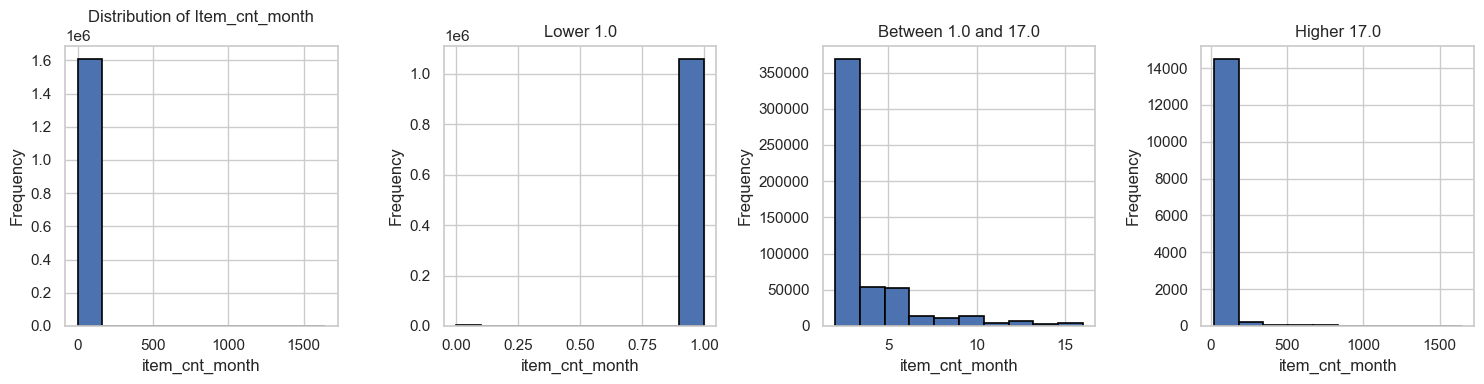

In [491]:
distribution(df_train, 'item_cnt_month')

Distribution of 'item_cnt_month' is right skewed, the biggest frequency we see with item_cnt_month = 1(1e6). It will be reasonable to do log transformation before training. Also we get 3 plots of different range(percentiles) of item_cnt_month values. 1st plot - 1%, 2nd - 1-99%, 3d - 99%. Most of the values are under 7.

In [492]:
print(f'Min of item_cnt_month is {min(df_train.item_cnt_month)}')
print(f'Max of item_cnt_month is {max(df_train.item_cnt_month)}')

Min of item_cnt_month is 0.0
Max of item_cnt_month is 1644.0


ITEM_PRICE

In [493]:
df_train[df_train.item_price < 0]

,date_block_num,shop_id,item_id,item_cnt_month,item_price


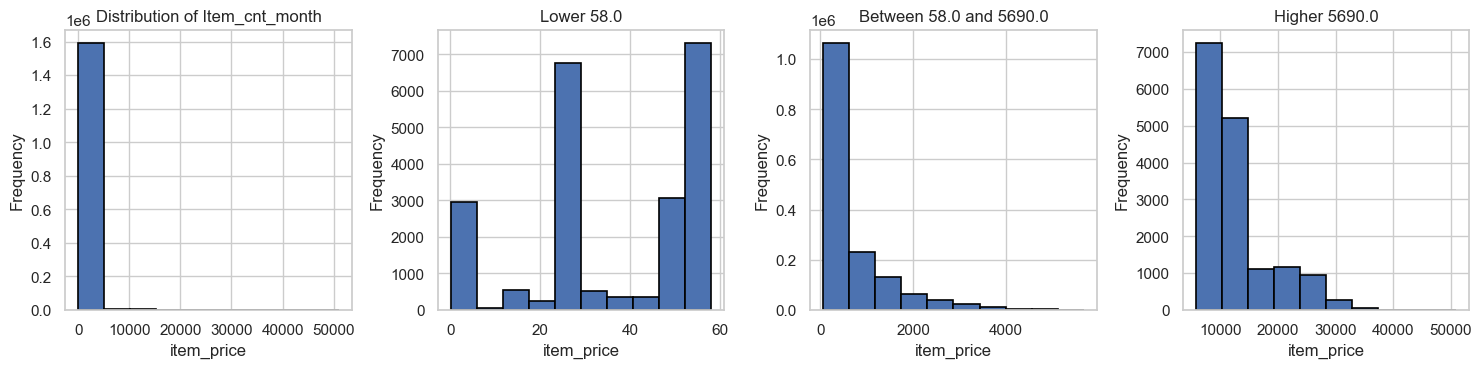

In [494]:
distribution(df_train, 'item_price')

Distribution of item price is right skewed. It will be also reasonable to make log transformation before training model

In [495]:
print(f'Min of item_price is {min(df_train.item_price)}')
print(f'Max of item_price is {max(df_train.item_price)}')

Min of item_price is 0.09
Max of item_price is 50999.0


Item_cnt_month behavior during the analyzed period

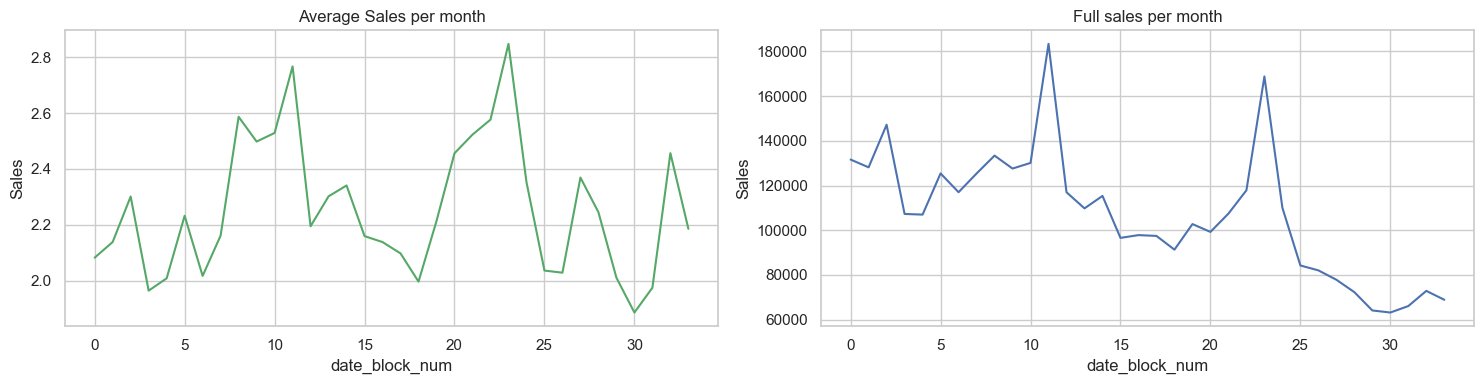

In [496]:
figure, ax = plt.subplots(1,2, figsize = (15,4))

sns.lineplot(data = df_train.groupby('date_block_num').agg({'item_cnt_month': 'mean'}), x = 'date_block_num', y = 'item_cnt_month', c = 'g', ax = ax[0]).set_title('Average Sales per month')

sns.lineplot(data = df_train.groupby('date_block_num').agg({'item_cnt_month': 'sum'}), x = 'date_block_num', y = 'item_cnt_month', c = 'b', ax = ax[1]).set_title('Full sales per month')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

Dependence of items sold on the time block show the presence of seasonality. Also, when analyzing the full sales for a month, we can see a tendency to decrease sales by the end of the analyzed period

Time-influenced features engineering

In [497]:
group = df_train.groupby('date_block_num').agg({'item_cnt_month': ['sum', 'mean']})
group = group.reset_index()
group['date'] = pd.date_range(start='2013-01-01', periods=34, freq='ME')
group['month'] = group['date'].dt.month
group['year'] = group['date'].dt.year

Item_cnt_month behavior during the year

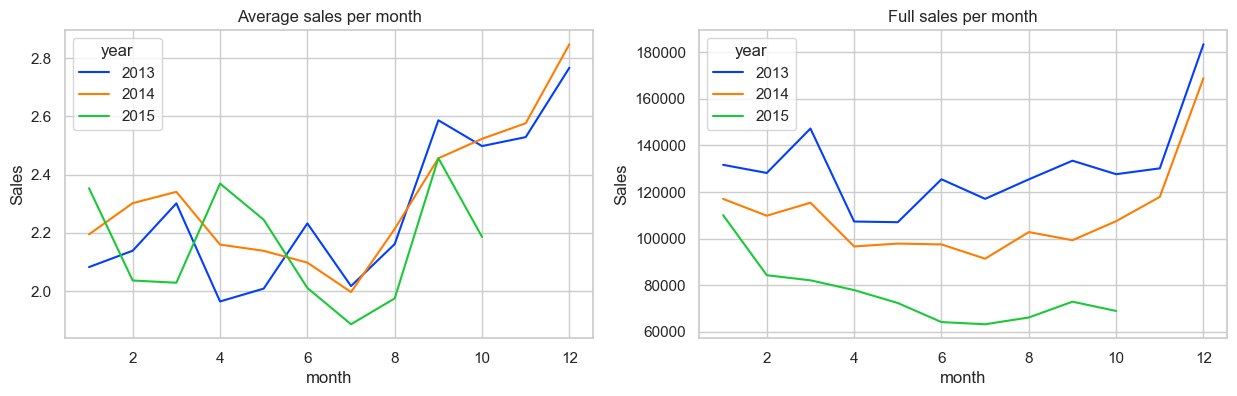

In [498]:
figure, ax = plt.subplots(1,2, figsize = (15,4))

sns.lineplot(data = group, x = 'month', y = ('item_cnt_month', 'mean'), hue = 'year', palette='bright', ax = ax[0]).set_title('Average sales per month')

sns.lineplot(data = group, x = 'month', y = ('item_cnt_month', 'sum'), hue = 'year', palette='bright', ax = ax[1]).set_title('Full sales per month')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.show()

Average sales: each period has it's own period of seasonality. Sales from the 2013 and 2014 years behave similarly. Dinamics of sales in 2015 started to differ (in the beggining and in the middle of the year). We do not have data to see how sales will behave at the end of 2015, but according to the general pattern - we will probably see an increase

Full sales: According to our data, sales have been declining with each subsequent year

In [499]:
group = group.droplevel(1, axis=1)[['date_block_num', 'month', 'year']]
df_train = pd.merge(df_train, group, on = 'date_block_num', how = 'left')

In [500]:
group = df_train.groupby('shop_id')['item_cnt_month'].sum().reset_index()
group = pd.merge(group, df_shops, on = 'shop_id', how = 'left')
sales_per_shop = group.sort_values(by = 'item_cnt_month', ascending = False)

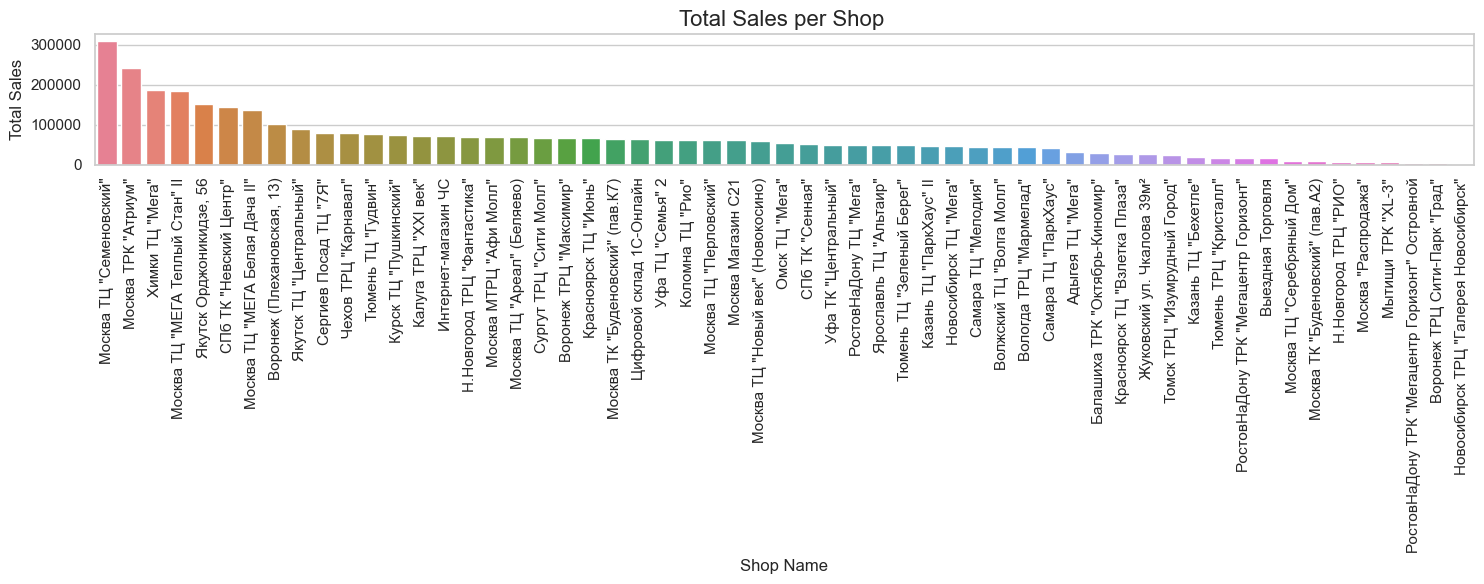

In [501]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_shop, x = 'shop_name', y = 'item_cnt_month', hue = 'shop_name')

plt.xticks(rotation=90)

plt.title('Total Sales per Shop ', fontsize=16)
plt.xlabel('Shop Name', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()
plt.show()

Sales depend on the type of shop and it's location. Most of the sales take place in big cities.

In [502]:
df_train = pd.merge(df_train, sales_per_shop.drop('item_cnt_month', axis = 1), on = 'shop_id', how = 'left')

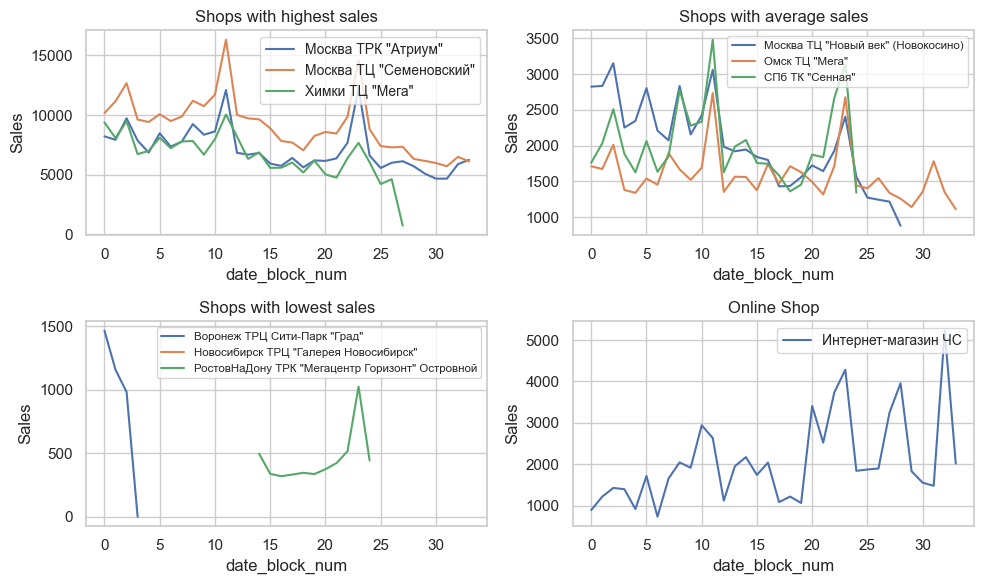

In [503]:
#Plotting sales change graphs with time period for highest, average and lowest sales for 3 shops each 
highest = pd.pivot_table(df_train[df_train.shop_id.isin(sales_per_shop[:3].shop_id.values)], values='item_cnt_month', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T
average = pd.pivot_table(df_train[df_train.shop_id.isin(sales_per_shop[(len(sales_per_shop)//2-1):(len(sales_per_shop)//2+2)].shop_id.values)], values='item_cnt_month', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T
lowest = pd.pivot_table(df_train[df_train.shop_id.isin(sales_per_shop[-3:].shop_id.values)], values='item_cnt_month', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T
online = pd.pivot_table(df_train[df_train.shop_name == 'Интернет-магазин ЧС'], values='item_cnt_month', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 6))

p1 = highest.plot(ax=axes[0,0], ylabel = 'Sales', title = 'Shops with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = average.plot(ax=axes[0,1], ylabel = 'Sales', title = 'Shops with average sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[1,0], ylabel = 'Sales', title = 'Shops with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')
p4 = online.plot(ax=axes[1,1], ylabel = 'Sales', title = 'Online Shop')
p4.legend(loc = 'upper right', fontsize = 'small')

plt.tight_layout()
plt.show()


1) Highest and middle sales
We see similar sales trends for different shops in the upper and middle sections. For some shops data is missing, but we see general trends and can make predictions if we fill in the missing values
2) Lowest sales
The graphs of the shops with the lowest sales show large data missing - making predictions on these shops can lead to errors. It would be logical to take a closer look at the shops that do not have data for the full analyzed period.
3) Online shop
Based on the overall graph, the online shop is 15th in terms of sales. However, it can be seen that closer to the end of the analyzed period, unlike offline shops, there is a tendency to increase sales.

C:\Users\User\AppData\Local\Temp\ipykernel_42256\2381355015.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize = 'x-small')


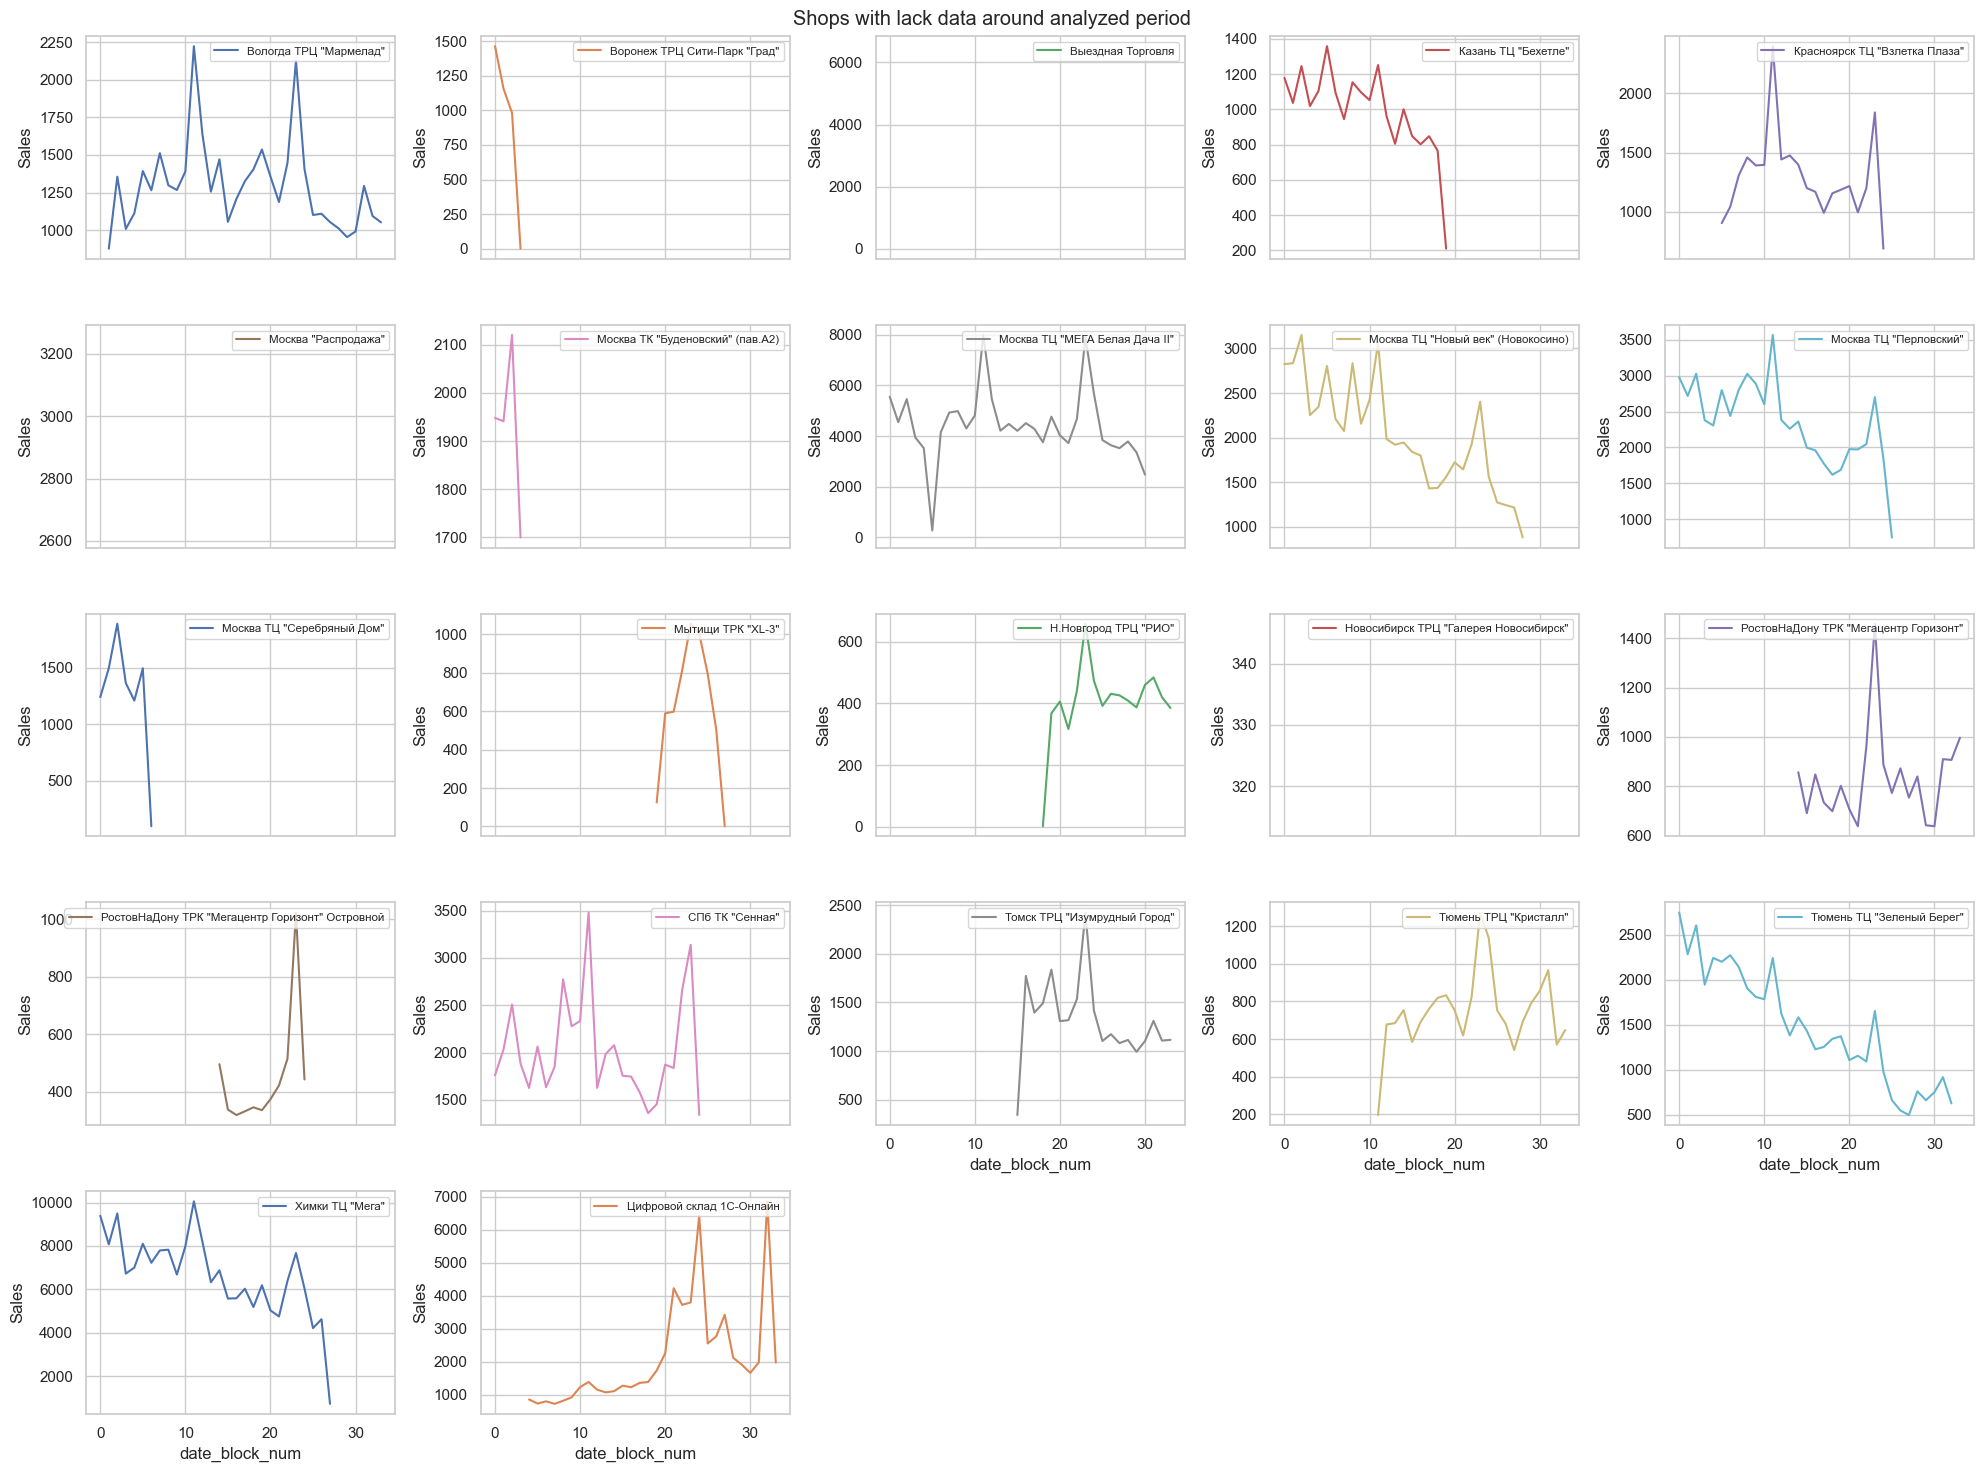

In [504]:
#Plotting not full data shops
shops = pd.pivot_table(df_train, values='item_cnt_month', columns=['date_block_num'], index=['shop_name'], aggfunc="sum")
axes = shops[shops.isna().any(axis = 1)].T.plot(subplots = True, layout = (5,5), grid=True,sharex=True, sharey=False,figsize=(20,15), title = 'Shops with lack data around analyzed period')

axes = axes.flat 

for ax in axes:
    
    ax.legend(loc='upper right', fontsize = 'x-small')
    ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()


For some shops we don't have trends even for one full year, they will add a lot of bias to our final model. But deleting them can be dangerous, because they could contain useful information for future predictions. In the future, it will be useful to add a feature that reflects the number of available time blocks for a store (shop history length), thereby factoring this into the prediction.

New feature: city

In [505]:
#Exctraction of city name from shop name
encoder = LabelEncoder()
df_shops['city'] = df_shops['shop_name'].str.split(' ').apply(lambda x: x[0])
df_shops.replace({'city': 'Сергиев'}, 'Сергиев Посад', inplace=True)
df_shops['city_id'] = encoder.fit_transform(df_shops['city'])

In [506]:
group = df_train.groupby('shop_id')['item_cnt_month'].sum().reset_index()
group = pd.merge(group, df_shops, on = 'shop_id', how = 'left')
sales_per_city = group.groupby(['city', 'city_id'])['item_cnt_month'].sum().reset_index().sort_values(by = 'item_cnt_month', ascending = False)

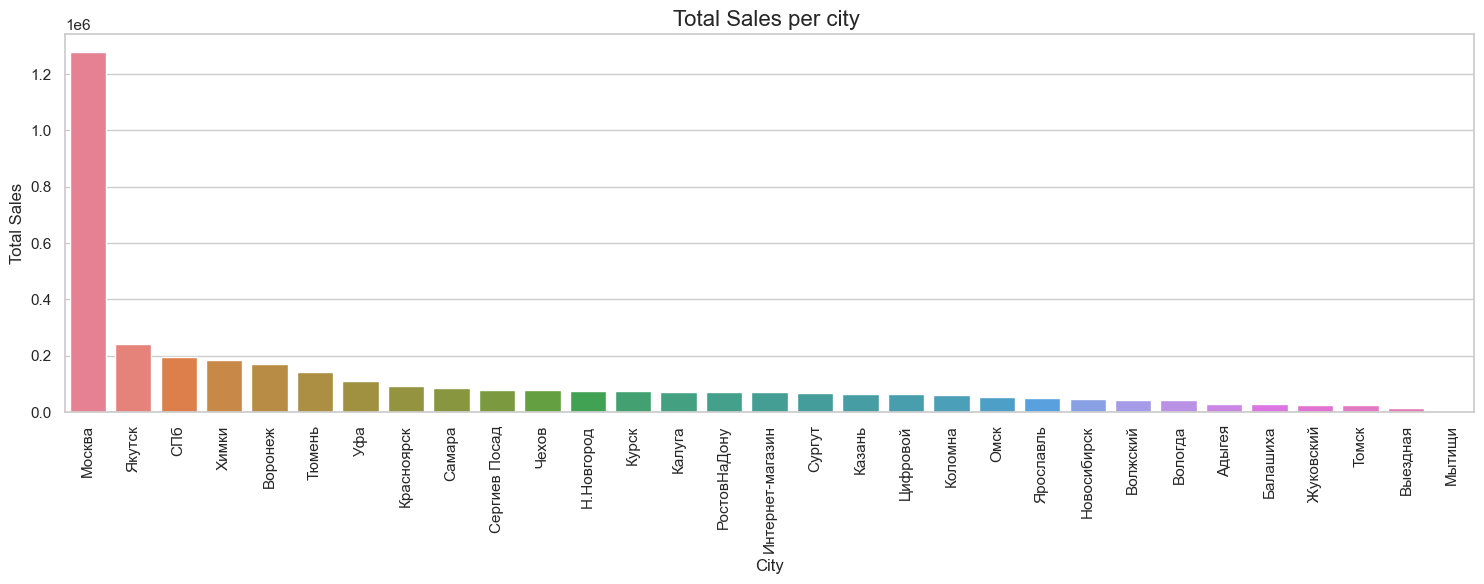

In [507]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_city, x = 'city', y = 'item_cnt_month', hue = 'city')

plt.xticks(rotation=90)

plt.title('Total Sales per city ', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()
plt.show()

Sales are higher in big cities. The highest sales are observed in the capital of the country - Moscow.

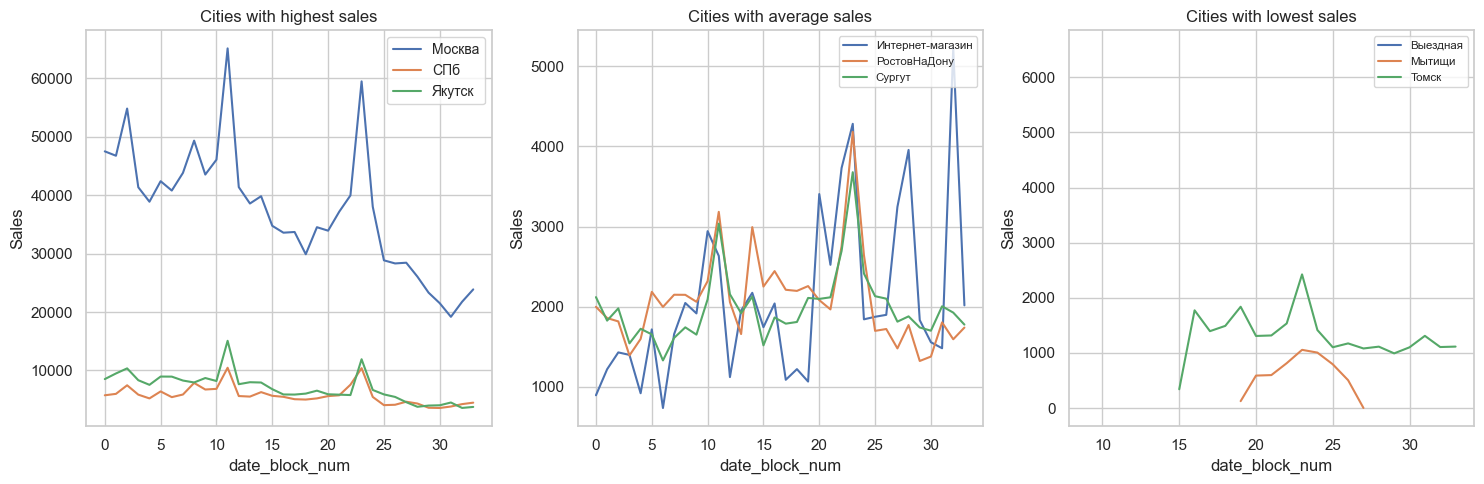

In [508]:
#Plotting sales change graphs with time period for highest, average and lowest sales for 3 city each 
highest = pd.pivot_table(df_train[df_train.city.isin(sales_per_city[:3].city.values)], values='item_cnt_month', columns=['date_block_num'], index=['city'], aggfunc="sum").T
average = pd.pivot_table(df_train[df_train.city.isin(sales_per_city[(len(sales_per_city)//2-1):(len(sales_per_city)//2+2)].city.values)], values='item_cnt_month', columns=['date_block_num'], index=['city'], aggfunc="sum").T
lowest = pd.pivot_table(df_train[df_train.city.isin(sales_per_city[-3:].city.values)], values='item_cnt_month', columns=['date_block_num'], index=['city'], aggfunc="sum").T

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

p1 = highest.plot(ax=axes[0], ylabel = 'Sales', title = 'Cities with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = average.plot(ax=axes[1], ylabel = 'Sales', title = 'Cities with average sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[2], ylabel = 'Sales', title = 'Cities with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


In all three groups of cities (with highest, average and middle level of sales) there is similar tendency in sales changes. Among all, Moscow stands out in terms of sales, as it contains the largest number of population and shops.

Item-price dependence

In [509]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month': 'sum', 'item_price': 'mean'}).reset_index()
group = group.groupby('item_price')['item_cnt_month'].sum().reset_index()

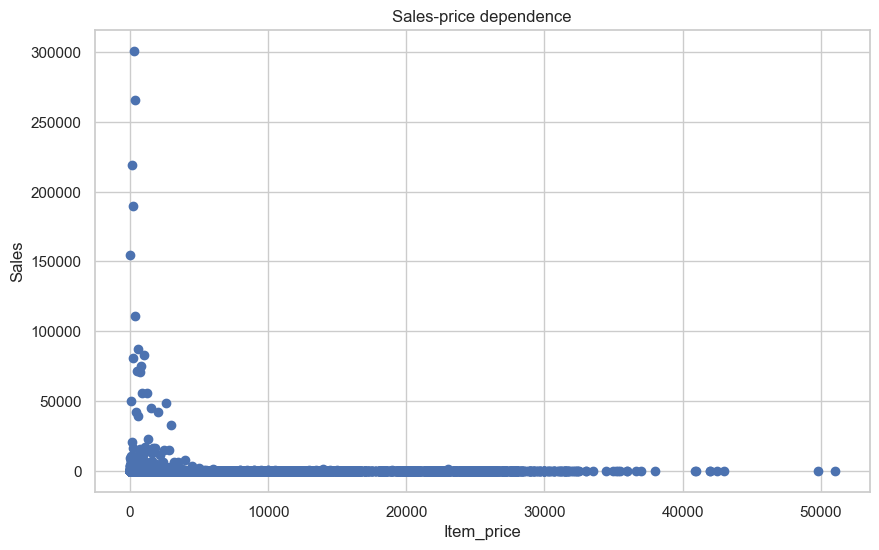

In [510]:
plt.figure(figsize=(10,6))
plt.scatter(x = group['item_price'],
            y = group['item_cnt_month'])

plt.xlabel('Item_price')
plt.ylabel('Sales')
plt.title('Sales-price dependence')

plt.show()

There is no linear correlation between sales per shop per item and item price. To illustrate sales in month dymanics on item price base, it will be reasonable to create new feature - revenue (item_price * item_cnt_month)

Item-category_id dependence

Split of category names into 2 parts: main and minor category

In [511]:
df_train = pd.merge(df_train, df_items, on = 'item_id', how = 'left')

In [512]:
df_item_categories['main_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[0])
df_item_categories.replace({'main_category': ['Игры PC', 'Игры Android', 'Игры MAC']}, 'Игры', inplace=True)
df_item_categories.replace({'main_category': ['Карты оплаты (Кино, Музыка, Игры)']}, 'Карты оплаты', inplace=True)
df_item_categories.replace({'main_category': ["PC", 'Чистые носители (штучные)', "Чистые носители (шпиль)", 'Чистые носители']}, 'Аксессуары', inplace=True)
df_item_categories.replace({'main_category': ["Билеты (Цифра)", 'Служебные']}, 'Билеты', inplace=True)
df_item_categories['main_category_id'] = encoder.fit_transform(df_item_categories['main_category'])
df_item_categories['minor_category'] = df_item_categories['item_category_name'].str.split(' - ').apply(lambda x: x[1] if len(x) > 1 else x[0])
df_item_categories['minor_category_id'] = encoder.fit_transform(df_item_categories['minor_category'])

In [513]:
group = df_train.groupby('item_category_id').agg({'item_cnt_month':'sum'}).reset_index()
group = pd.merge(group, df_item_categories, on = 'item_category_id', how = 'left')
sales_per_main_category = group.groupby('main_category').agg({'item_cnt_month':'sum'}).sort_values(by = 'item_cnt_month', ascending = False).reset_index()

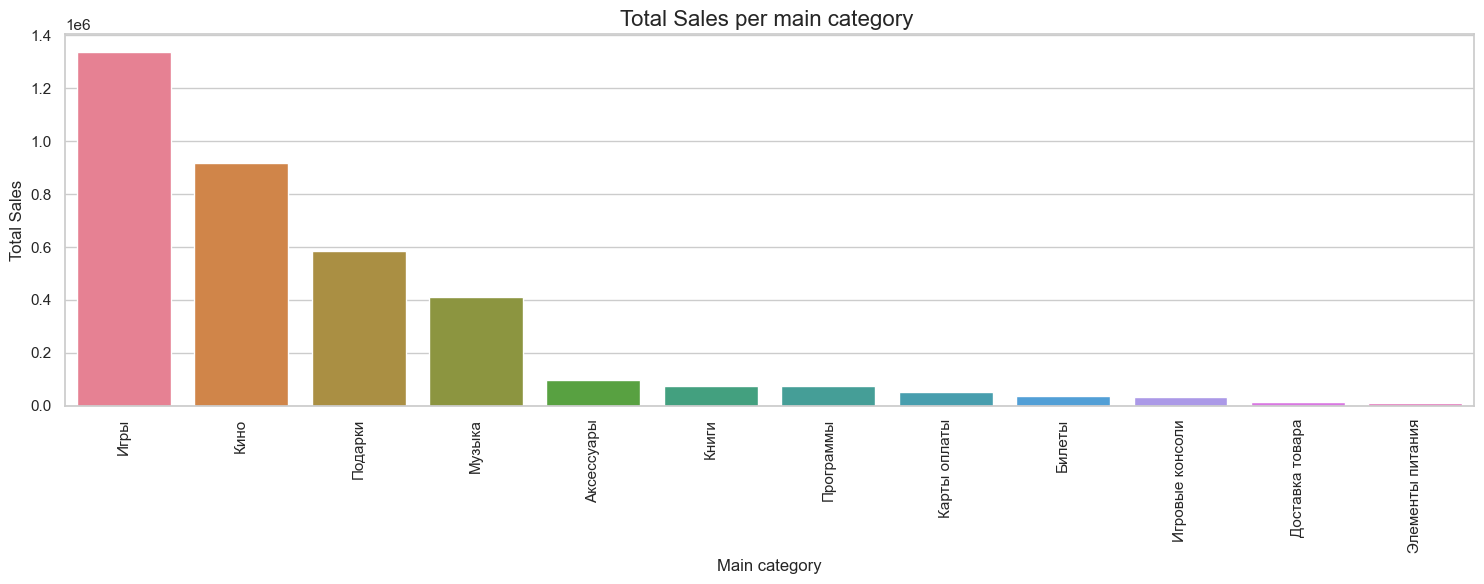

In [514]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_main_category, x = 'main_category', y = 'item_cnt_month', hue = 'main_category')

plt.xticks(rotation=90)

plt.title('Total Sales per main category ', fontsize=16)
plt.xlabel('Main category', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()
plt.show()

The highest number of sales is in categories such as Games, Movies and Gifts. The lowest sales in the categories of batteries, which may be due to product specificity.

In [515]:
sales_per_minor_category = group.groupby(['main_category', 'minor_category']).agg({'item_cnt_month':'sum'}).sort_values(by = 'item_cnt_month', ascending = False).reset_index()

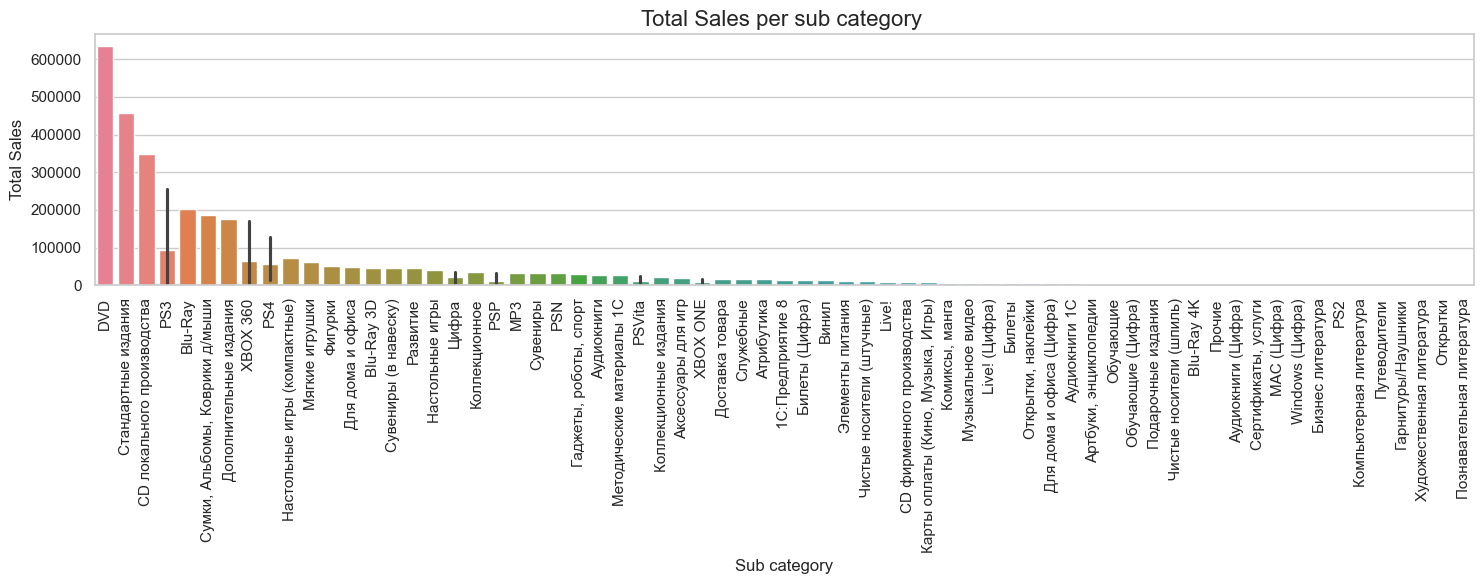

In [516]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_minor_category, x = 'minor_category', y = 'item_cnt_month', hue = 'minor_category')

plt.xticks(rotation=90)

plt.title('Total Sales per sub category ', fontsize=16)
plt.xlabel('Sub category', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()

Plot of 15th most and minor popular subcategories slice -to get more interpritable picture

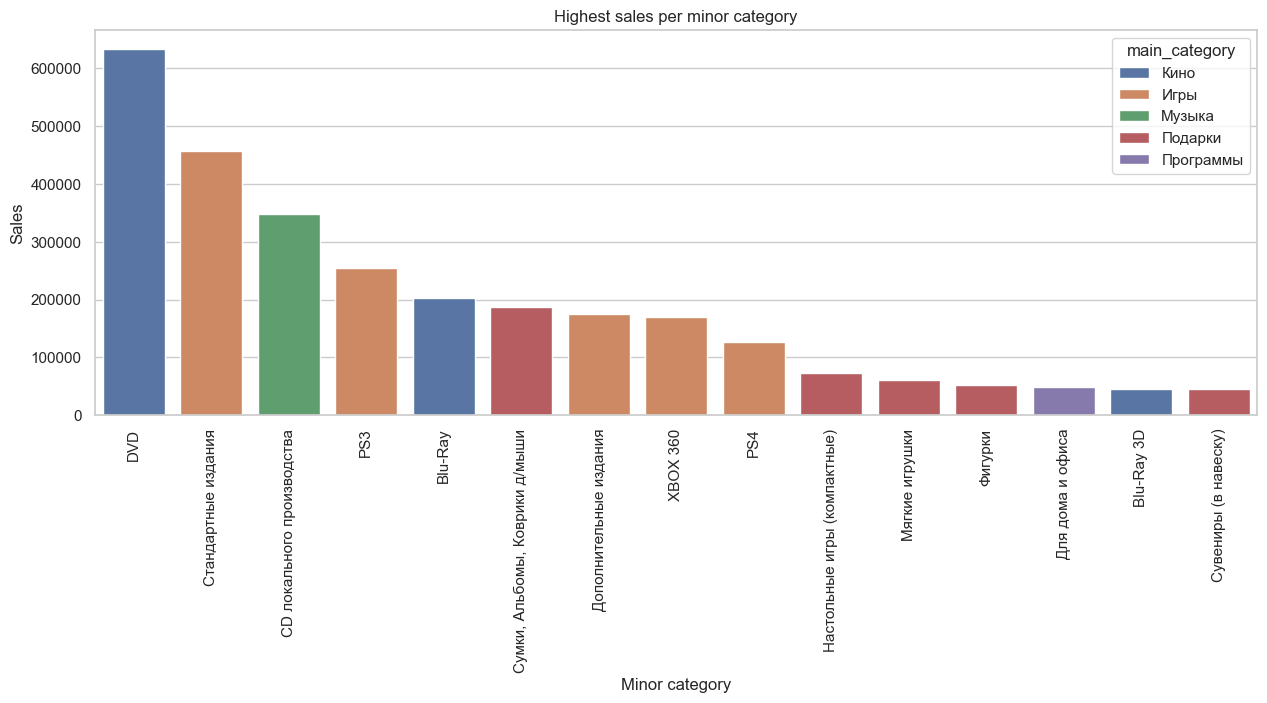

In [517]:
plt.figure(figsize = (15,5))

sns.barplot(data = sales_per_minor_category[:15], x = 'minor_category', y = 'item_cnt_month', hue = 'main_category')

plt.title('Highest sales per minor category')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

The largest sales for main category 'Movies' in DVD format, while in Blu-Ray have smaller sales. There are no sales from the 'Cinema' category in less preffered segment. Games sold for PC-стандартные издания, take second place among customers (PC-дополнительные издания are also in the top 15 best-selling subcategories with games for PS3, PS4 and XBOX-360).
Music sold on CDs is on the third place.

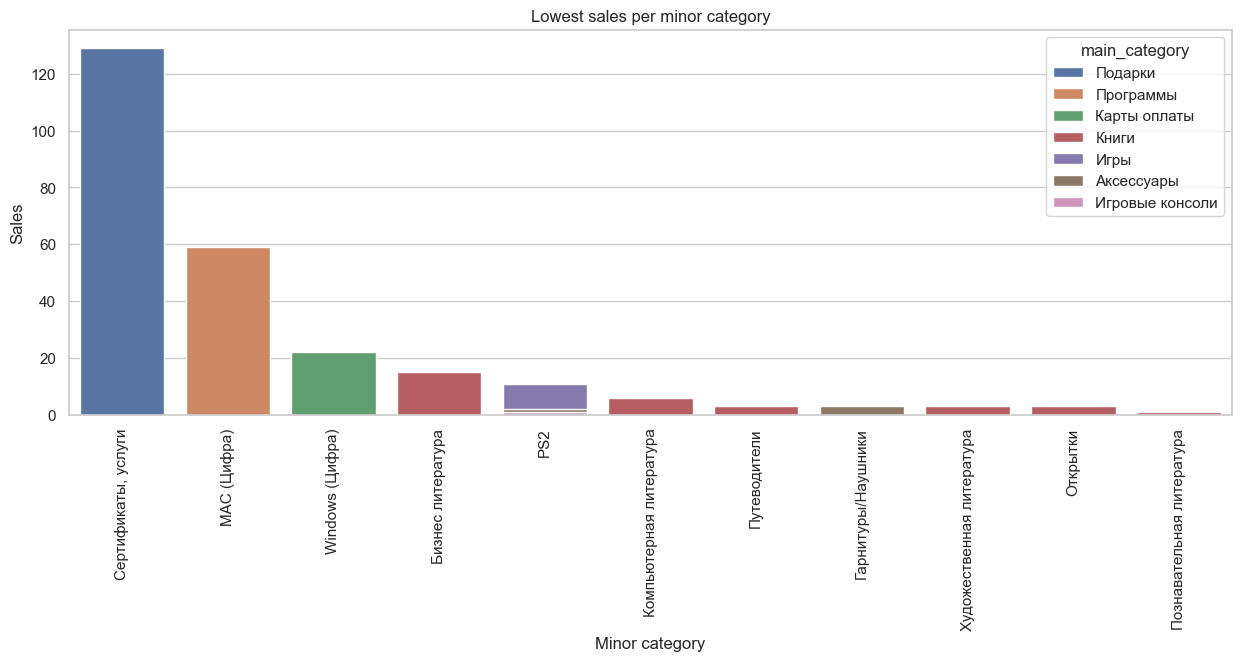

In [518]:
plt.figure(figsize = (15,5))

sns.barplot(data = sales_per_minor_category[69:], x = 'minor_category', y = 'item_cnt_month', hue = 'main_category', dodge=False)

plt.title('Lowest sales per minor category')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

The slice with the lowest sales included printed products from the category 'Books'. Category 'Games' is very popular among customers, although games sold for PS2 are less preferred

Time-dependence of different categories

In [519]:
df_train = pd.merge(df_item_categories, df_train, on = 'item_category_id', how = 'left')

Time tendencies for category

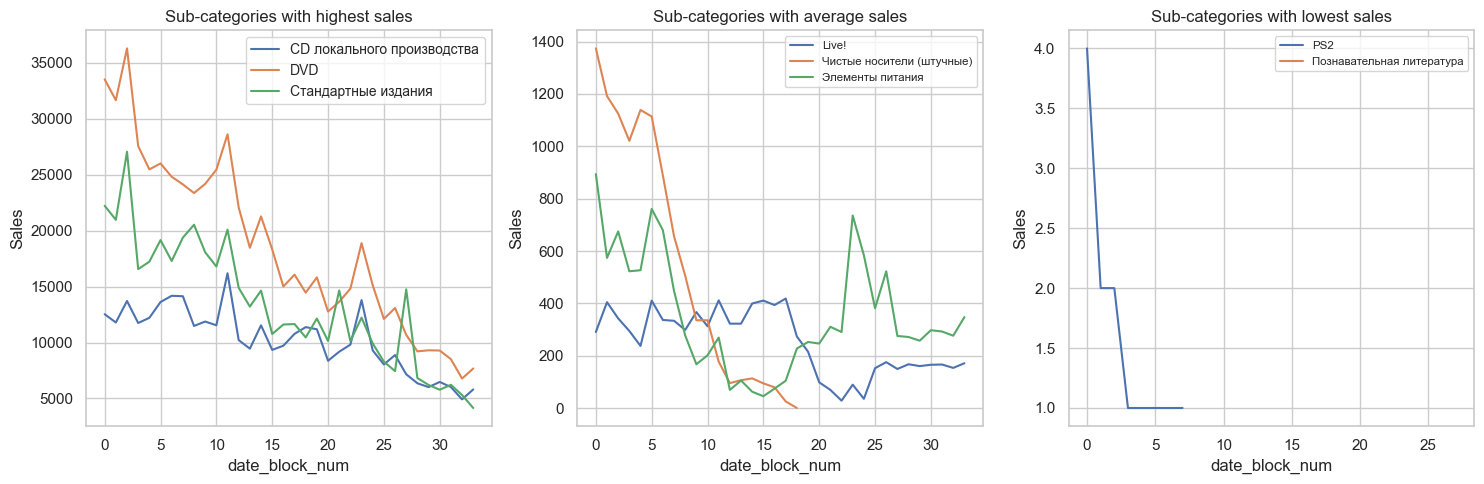

In [520]:
#Plotting sales change graphs with time period for highest, average and lowest sales for 3 category each 
highest = pd.pivot_table(df_train[df_train.minor_category.isin(sales_per_minor_category[:3].minor_category.values)], values='item_cnt_month', columns=['date_block_num'], index=['minor_category'], aggfunc="sum").T
average = pd.pivot_table(df_train[df_train.minor_category.isin(sales_per_minor_category[(len(sales_per_minor_category)//2-1):(len(sales_per_minor_category)//2+2)].minor_category.values)], values='item_cnt_month', columns=['date_block_num'], index=['minor_category'], aggfunc="sum").T
lowest = pd.pivot_table(df_train[df_train.minor_category.isin(sales_per_minor_category[-3:].minor_category.values)], values='item_cnt_month', columns=['date_block_num'], index=['minor_category'], aggfunc="sum").T

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

p1 = highest.plot(ax=axes[0], ylabel = 'Sales', title = 'Sub-categories with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = average.plot(ax=axes[1], ylabel = 'Sales', title = 'Sub-categories with average sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[2], ylabel = 'Sales', title = 'Sub-categories with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_42256\4119027726.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize = 'x-small')


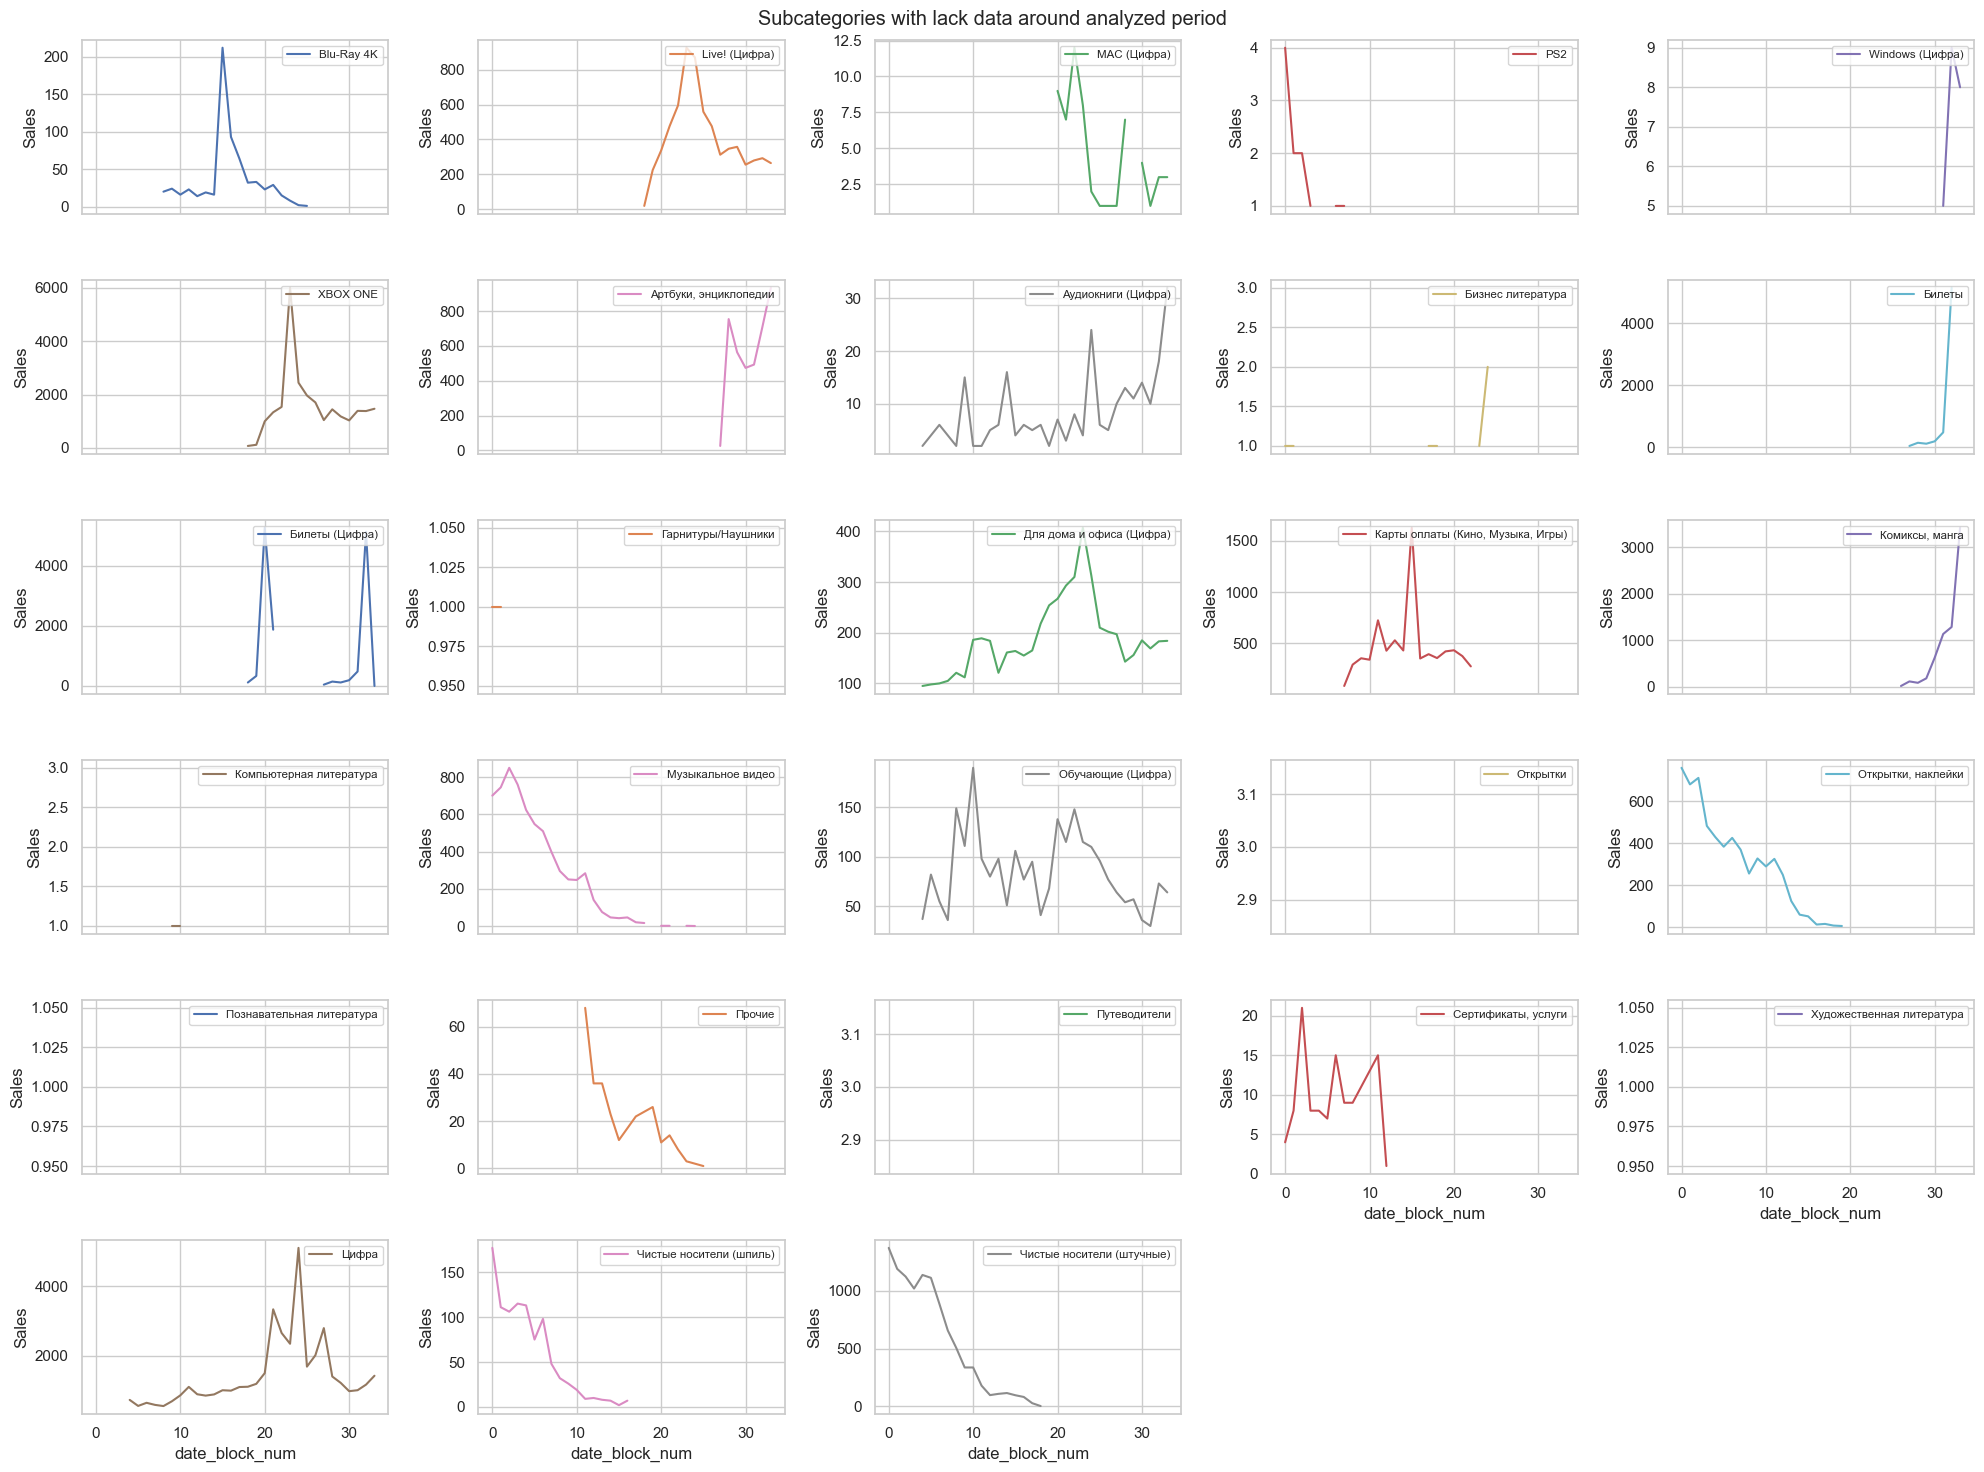

Percentage of subcategories with missings: 42%


In [521]:
#Plotting not full data subcategories
subcategories = pd.pivot_table(df_train, values='item_cnt_month', columns=['date_block_num'], index=['minor_category'], aggfunc="sum")
axes = subcategories[subcategories.isna().any(axis = 1)].T.plot(subplots = True, layout = (6,5), grid=True,sharex=True, sharey=False,figsize=(20,15), title = 'Subcategories with lack data around analyzed period')

axes = axes.flat 

for ax in axes:
    
    ax.legend(loc='upper right', fontsize = 'x-small')
    ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()

sub = len(df_train.minor_category.unique())
unc_sub = len(subcategories[subcategories.isna().any(axis = 1)])
perc = unc_sub / sub
print(f'Percentage of subcategories with missings: {perc:.0%}')

For the subcategories with the most sales, we see a general trend of decreasing sales over time. For the categories with the average number of sales, the trends are different, and missing pieces of data are starting to appear. For the subcategories with the lowest number of sales, there is almost no data.

Almost all incomplete subcategories contain less than 50% of data around analyzed period. Moreover, the percentage of uncomplete subcategories 42%. Just like for shops, in the future it will be useful to also add a feature that reflects the number of available time blocks for a subcategory (minor history length), thereby factoring this into the prediction.

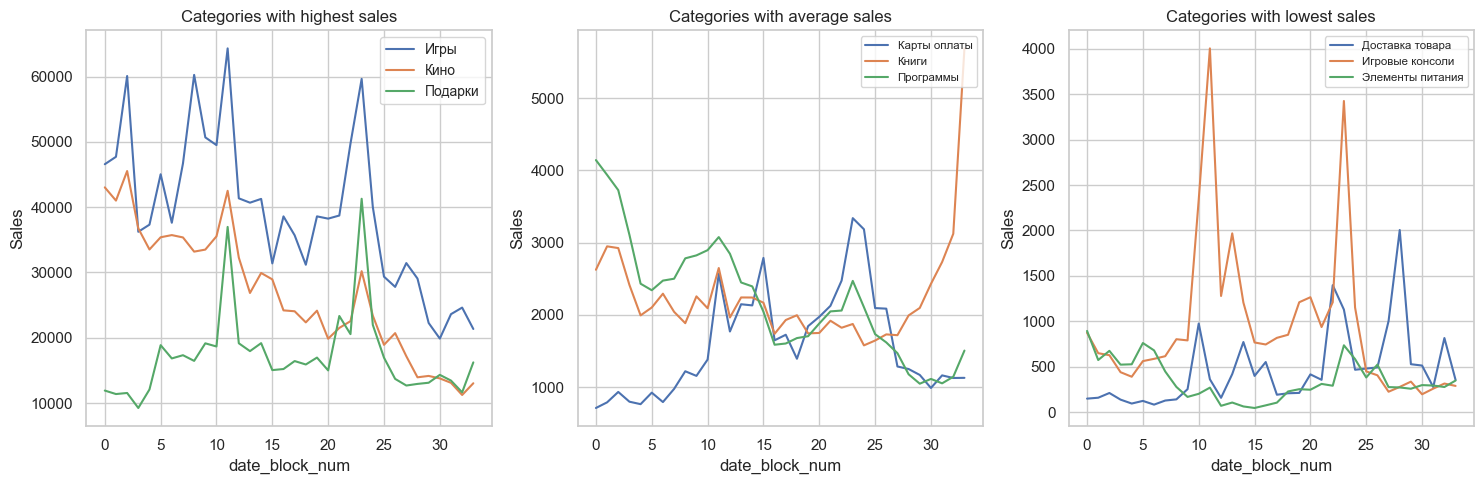

In [522]:
#Plotting sales change graphs with time period for highest, average and lowest sales for 3 category each 
highest = pd.pivot_table(df_train[df_train.main_category.isin(sales_per_main_category[:3].main_category.values)], values='item_cnt_month', columns=['date_block_num'], index=['main_category'], aggfunc="sum").T
average = pd.pivot_table(df_train[df_train.main_category.isin(sales_per_main_category[(len(sales_per_main_category)//2-1):(len(sales_per_main_category)//2+2)].main_category.values)], values='item_cnt_month', columns=['date_block_num'], index=['main_category'], aggfunc="sum").T
lowest = pd.pivot_table(df_train[df_train.main_category.isin(sales_per_main_category[-3:].main_category.values)], values='item_cnt_month', columns=['date_block_num'], index=['main_category'], aggfunc="sum").T

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

p1 = highest.plot(ax=axes[0], ylabel = 'Sales', title = 'Categories with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = average.plot(ax=axes[1], ylabel = 'Sales', title = 'Categories with average sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[2], ylabel = 'Sales', title = 'Categories with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


Almost all categories show a decline in sales during the analyzed period. At the end of the period for the Books category, a spike in sales is visible, which may indicate an outlier. Bright seasonality is observed for the Game Consoles category towards the end of each year.

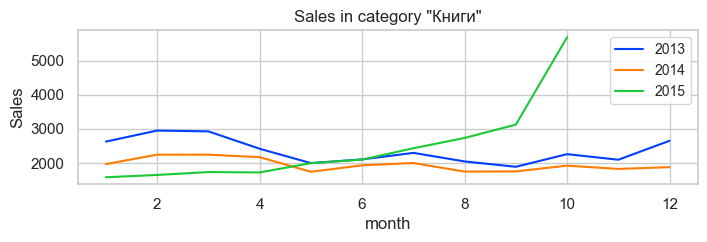

In [523]:
#Plot of category Книги
group = df_train.groupby(['year', 'month', 'main_category'])['item_cnt_month'].sum().reset_index()
plt.figure(figsize = (8,2))

sns.lineplot(data = group[group.main_category == 'Книги'], x = 'month', y = 'item_cnt_month', hue = 'year', palette='bright').set_title('Sales in category "Книги"')

plt.ylabel('Sales')
plt.legend(loc = 'upper right', fontsize = 'small')

plt.show()

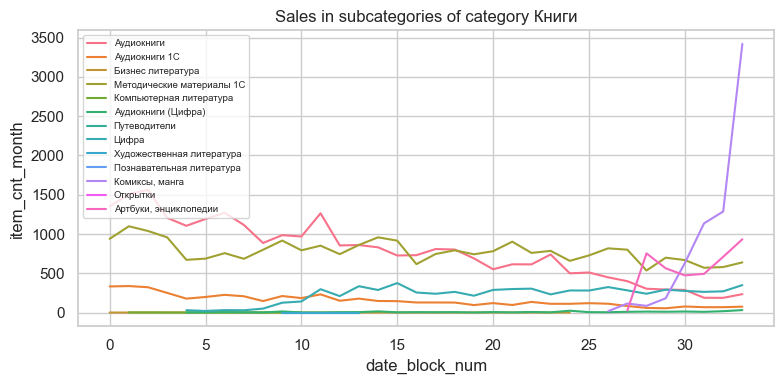

In [524]:
group = df_train[df_train.main_category == 'Книги'].groupby(['date_block_num', 'minor_category'])['item_cnt_month'].sum().reset_index()
plt.figure(figsize = (8,4))

sns.lineplot(group, x = 'date_block_num', y = 'item_cnt_month', hue = 'minor_category')

plt.legend(loc = 'upper left', fontsize = 'xx-small')
plt.title('Sales in subcategories of category Книги')

plt.tight_layout()
plt.show()

In [525]:
#Check if we have this items in test set
df_test = pd.read_csv('./competitive-data-science-predict-future-sales/test.csv')
manga_id = list(df_train[df_train.minor_category == 'Комиксы, манга'].item_id.unique())
len(df_test[df_test.item_id.isin(manga_id)])

5334

We see a jump in sales for the Comics and Manga subcategory. Sales data for this product is available for the last 8 months. It would be dangerous to remove the data, as we would need to make predictions for products including those from this category.

main categories and item_cnt_month

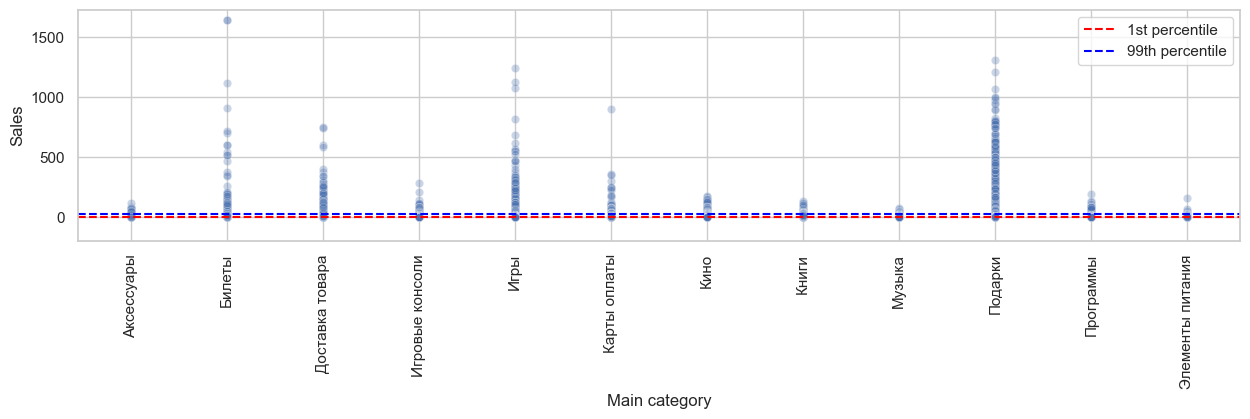

In [526]:
q1 = df_train['item_cnt_month'].quantile(0.05)
q99 = df_train['item_cnt_month'].quantile(0.995)

plt.figure(figsize = (15,3))
sns.scatterplot(data = df_train, x = df_train.main_category, y = df_train.item_cnt_month, alpha=0.3)

plt.axhline(q1, color='red', linestyle='--', label='1st percentile')
plt.axhline(q99, color='blue', linestyle='--', label='99th percentile')

plt.xlabel('Main category')
plt.ylabel('Sales')
plt.ylim(bottom = -200)

plt.legend()
plt.xticks(rotation=90)
plt.show()

Tickets

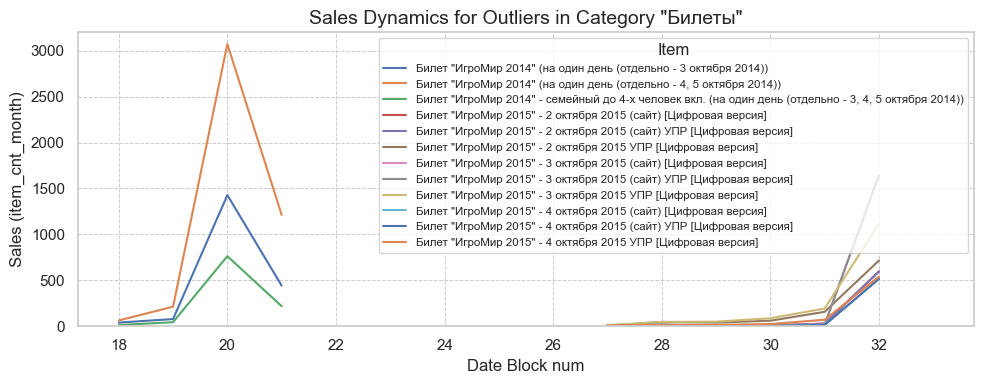

In [527]:
sns.set(style="whitegrid")

tickets_outliers = df_train[(df_train.main_category == 'Билеты') & (df_train.item_cnt_month > 250)]
tickets_outliers = pd.merge(tickets_outliers, df_items, on = 'item_id', how = 'left')
tickets_item_id = list(tickets_outliers.item_id.unique())

pivot_data = pd.pivot_table(df_train[df_train.item_id.isin(tickets_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_cnt_month', 
                            aggfunc="sum").T


plt.figure(figsize=(10,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Sales (item_cnt_month)', fontsize=12)
plt.title('Sales Dynamics for Outliers in Category "Билеты"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.ylim(0, 3200)

plt.legend(title='Item', loc='upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


There are no outliers for this category, as such products are characterized by high sales for one period and no sales for another.

Cards

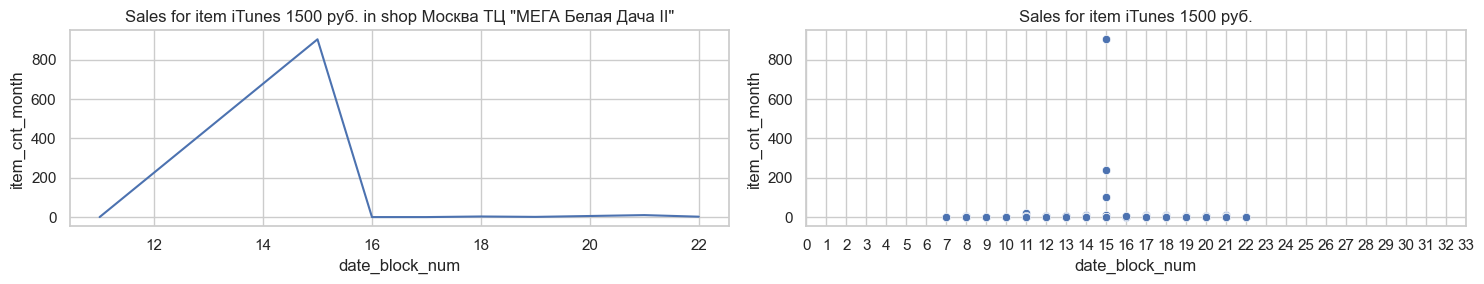

In [528]:
cards_outlier = df_train[(df_train.main_category == 'Карты оплаты') & (df_train.item_cnt_month > 750)]
shop_id_out = cards_outlier.shop_id.values[0]
item_id_out = cards_outlier.item_id.values[0]
fig,axes = plt.subplots(1,2, figsize = (15,3))
sns.lineplot(data = df_train[(df_train.shop_id == shop_id_out) & (df_train.item_id == item_id_out)], x = 'date_block_num', y = 'item_cnt_month', ax = axes[0])
axes[0].set_title(f'Sales for item {df_items[df_items.item_id == item_id_out].iloc[0]['item_name']} in shop {df_shops[df_shops.shop_id == shop_id_out].iloc[0]['shop_name']}')
sns.scatterplot(data = df_train[df_train.item_id == item_id_out], x = 'date_block_num', y = 'item_cnt_month', ax = axes[1])

plt.xticks(ticks=range(0,34))
plt.title(f'Sales for item {df_items[df_items.item_id == item_id_out].iloc[0]['item_name']}')

plt.tight_layout()
plt.show()

The charts show that selling over 800 for the 15th time block is an outlier

In [529]:
df_train.drop(df_train[(df_train.shop_id == shop_id_out) & (df_train.item_id == item_id_out) & (df_train.date_block_num == 15)].index, inplace = True)

Delivery

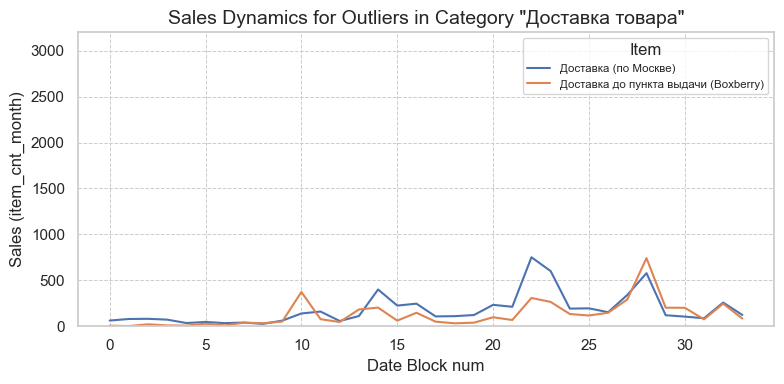

In [530]:
sns.set(style="whitegrid")

delivery_outliers = df_train[(df_train.main_category == 'Доставка товара') & (df_train.item_cnt_month > 500)]
delivery_outliers = pd.merge(delivery_outliers, df_items, on = 'item_id', how = 'left')
delivery_item_id = list(delivery_outliers.item_id.unique())

pivot_data = pd.pivot_table(df_train[df_train.item_id.isin(delivery_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_cnt_month', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Sales (item_cnt_month)', fontsize=12)
plt.title('Sales Dynamics for Outliers in Category "Доставка товара"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.ylim(0, 3200)

plt.legend(title='Item', loc='upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


For this category there are no outliers, increased sales are for the city of Moscow, where sales for all categories are very different compared to other cities.

Games

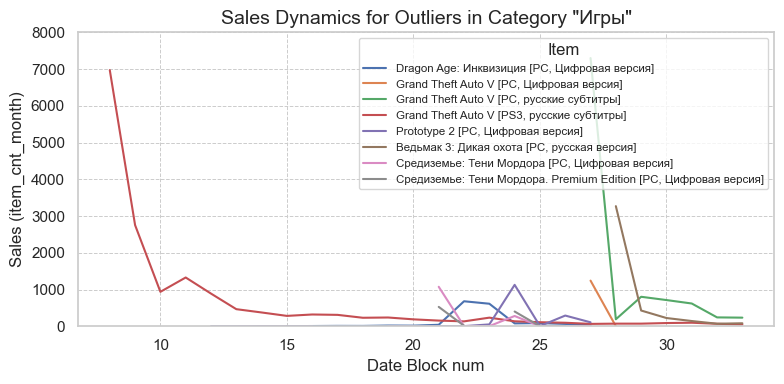

In [531]:
sns.set(style="whitegrid")

games_outliers = df_train[(df_train.main_category == 'Игры') & (df_train.item_cnt_month > 500)]
games_outliers = pd.merge(games_outliers, df_items, on = 'item_id', how = 'left')
games_item_id = list(games_outliers.item_id.unique())

pivot_data = pd.pivot_table(df_train[df_train.item_id.isin(games_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_cnt_month', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Sales (item_cnt_month)', fontsize=12)
plt.title('Sales Dynamics for Outliers in Category "Игры"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.ylim(0, 8000)

plt.legend(title='Item', loc='upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


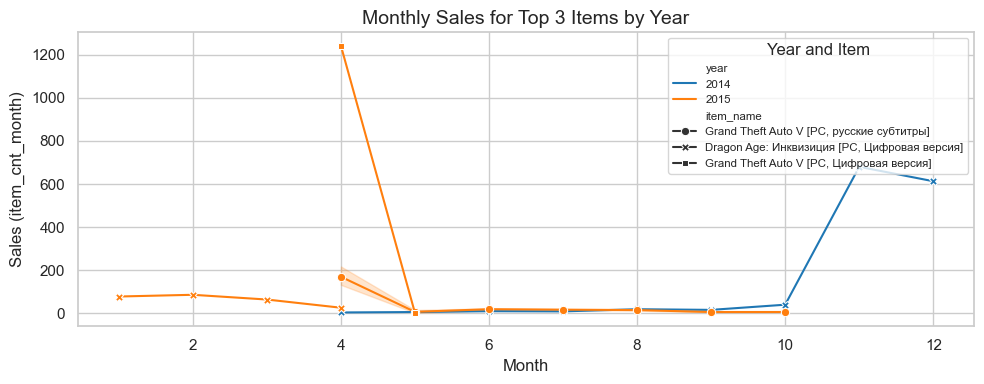

In [532]:
top_items = games_outliers.groupby('item_id')['item_cnt_month'].sum().nlargest(3).index
top_items_data = df_train[df_train['item_id'].isin(top_items)]

plt.figure(figsize=(10,4))

sns.lineplot(data=top_items_data, x='month', y='item_cnt_month', hue='year', 
             style='item_name', markers=True, dashes=False, palette='tab10')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales (item_cnt_month)', fontsize=12)

plt.title('Monthly Sales for Top 3 Items by Year', fontsize=14)


plt.legend(title='Year and Item', loc='upper right', fontsize = 'x-small')

plt.grid(True)

plt.tight_layout()
plt.show()


In [533]:
df_test[df_test['item_id'].isin(top_items)].item_id.unique(), top_items

(array([3731]), Index([3731, 3025, 3730], dtype='int64', name='item_id'))

Item with id == 3025 have no data for 2015 year and have extreme values, also item with id == 3730 have extreme values for item_cnt_month, that will give us a lot of bias to our final model. We do not have them in test set, so we can safely exlude them from our data.

In [534]:
df_train.drop(df_train[(df_train.item_id.isin([3025,3730]))].index, inplace = True)

Gifts

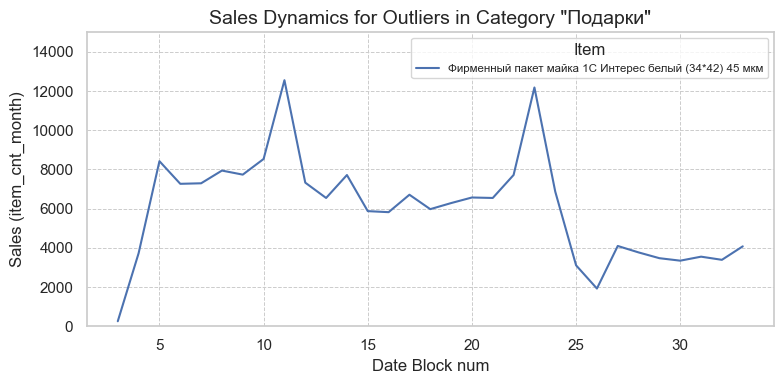

In [535]:
sns.set(style="whitegrid")

gifts_outliers = df_train[(df_train.main_category == 'Подарки') & (df_train.item_cnt_month > 250)]
gifts_outliers = pd.merge(gifts_outliers, df_items, on = 'item_id', how = 'left')
gifts_item_id = list(gifts_outliers.item_id.unique())

pivot_data = pd.pivot_table(df_train[df_train.item_id.isin(gifts_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_cnt_month', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Sales (item_cnt_month)', fontsize=12)
plt.title('Sales Dynamics for Outliers in Category "Подарки"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.ylim(0, 15000)

plt.legend(title='Item', loc='upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()

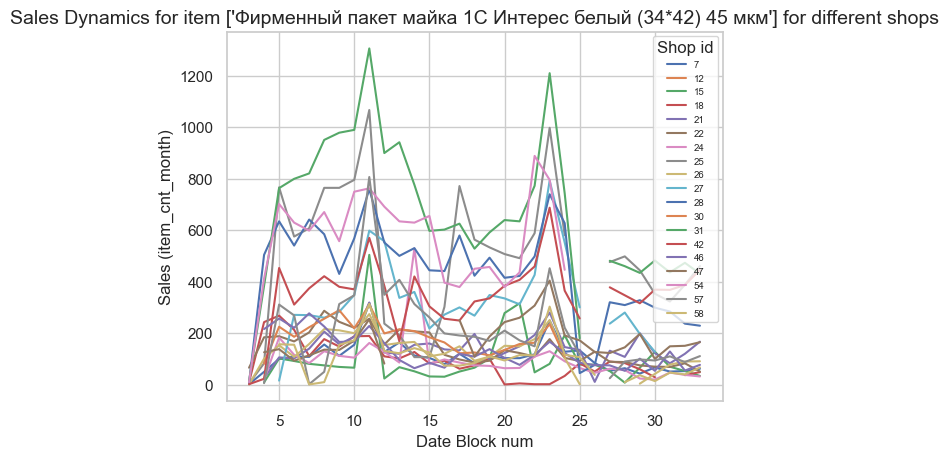

In [536]:
sns.set(style="whitegrid")
gifts = df_train[(df_train.item_id == gifts_item_id[0]) & (df_train.shop_id.isin(gifts_outliers.shop_id.unique()))]
pd.pivot_table(data = gifts, columns = 'date_block_num', index = 'shop_id', values = 'item_cnt_month', aggfunc = 'sum').T.plot()

plt.legend(title = 'Shop id', loc = 'upper right', fontsize = 'xx-small')

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Sales (item_cnt_month)', fontsize=12)
plt.title(f'Sales Dynamics for item {df_items[df_items.item_id == gifts_item_id[0]]['item_name'].unique()} for different shops', fontsize=14)

plt.show()

From the type of the product and dinamics of sales among different shows, some sales increase is logically explained.

Main categories and item price

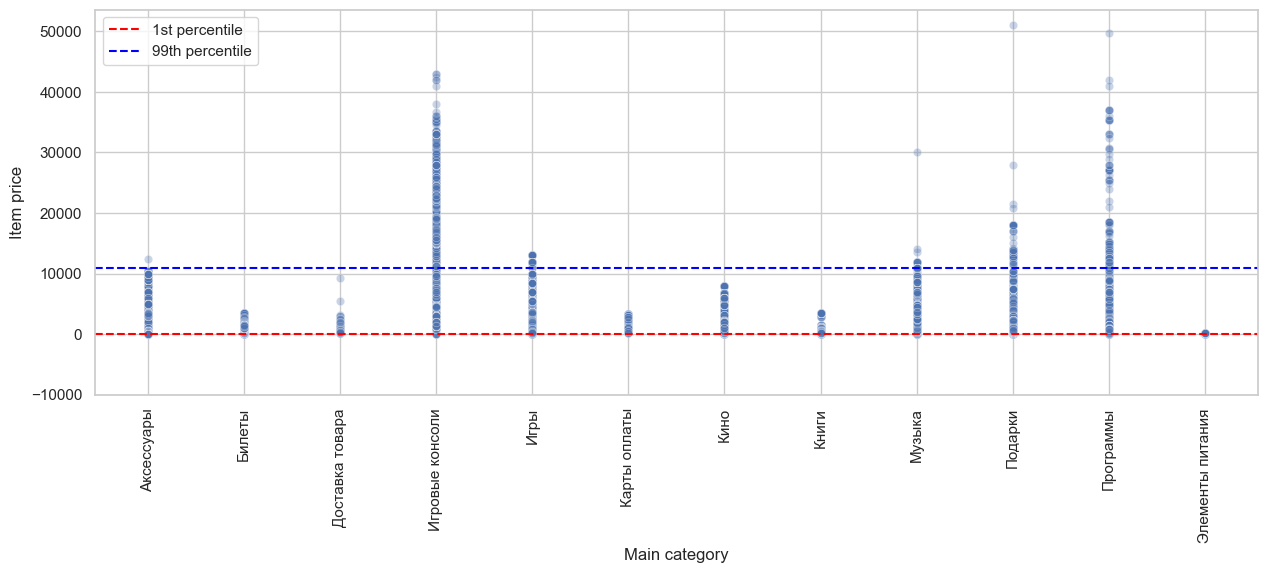

In [537]:
q1 = df_train['item_price'].quantile(0.05)
q99 = df_train['item_price'].quantile(0.995)

plt.figure(figsize = (15,5))
sns.scatterplot(data = df_train, x = df_train.main_category, y = df_train.item_price, alpha=0.3)

plt.axhline(q1, color='red', linestyle='--', label='1st percentile')
plt.axhline(q99, color='blue', linestyle='--', label='99th percentile')

plt.xlabel('Main category')
plt.ylabel('Item price')

plt.legend()
plt.xticks(rotation=90)

plt.ylim(bottom = -10000)
plt.show()

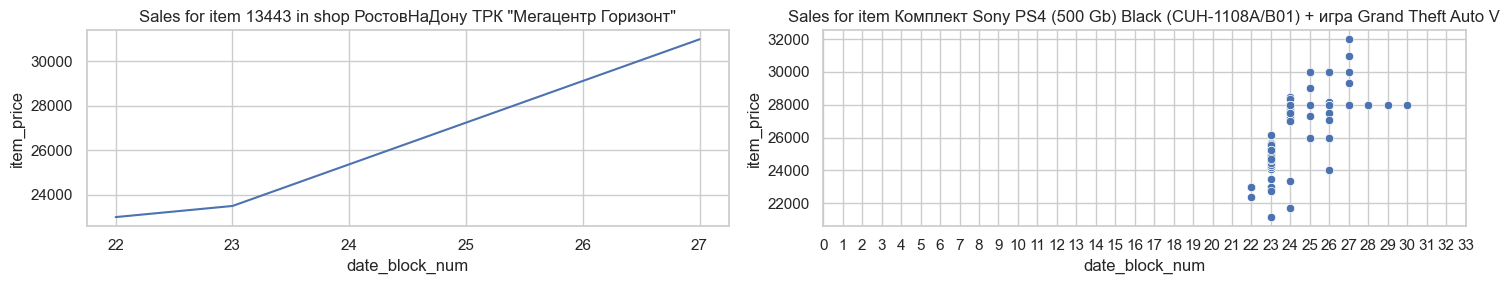

In [538]:
consols_outlier = df_train[(df_train.main_category == 'Игровые консоли') & (df_train.item_price > 30000)]
shop_id_out = consols_outlier.shop_id.values[0]
item_id_out = consols_outlier.item_id.values[0]
fig,axes = plt.subplots(1,2, figsize = (15,3))
sns.lineplot(data = df_train[(df_train.shop_id == shop_id_out) & (df_train.item_id == item_id_out)], x = 'date_block_num', y = 'item_price', ax = axes[0])
axes[0].set_title(f'Sales for item {item_id_out} in shop {df_shops[df_shops.shop_id == shop_id_out].iloc[0]['shop_name']}')
sns.scatterplot(data = df_train[df_train.item_id == item_id_out], x = 'date_block_num', y = 'item_price', ax = axes[1])

plt.xticks(ticks=range(0,34))
plt.title(f'Sales for item {df_items[df_items.item_id == item_id_out].iloc[0]['item_name']}')

plt.tight_layout()
plt.show()

The price increase is probably due to the approaching game release date

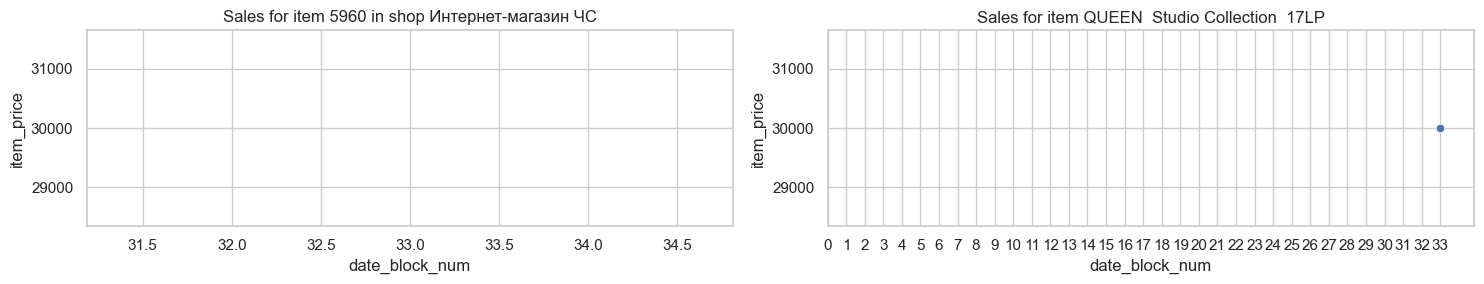

In [539]:
music_outlier = df_train[(df_train.main_category == 'Музыка') & (df_train.item_price > 20000)]
shop_id_out = music_outlier.shop_id.values[0]
item_id_out = music_outlier.item_id.values[0]
fig,axes = plt.subplots(1,2, figsize = (15,3))
sns.lineplot(data = df_train[(df_train.shop_id == shop_id_out) & (df_train.item_id == item_id_out)], x = 'date_block_num', y = 'item_price', ax = axes[0])
axes[0].set_title(f'Sales for item {item_id_out} in shop {df_shops[df_shops.shop_id == shop_id_out].iloc[0]['shop_name']}')
sns.scatterplot(data = df_train[df_train.item_id == item_id_out], x = 'date_block_num', y = 'item_price', ax = axes[1])

plt.xticks(ticks=range(0,34))
plt.title(f'Sales for item {df_items[df_items.item_id == item_id_out].iloc[0]['item_name']}')

plt.tight_layout()
plt.show()

In [540]:
df_test[df_test.item_id == 5960]

,ID,shop_id,item_id


We do not have it in test set, also it contains data only for one sale. It will be reasonable to drop it.

In [541]:
df_train.drop(df_train[(df_train.item_id == 5960)].index, inplace = True)

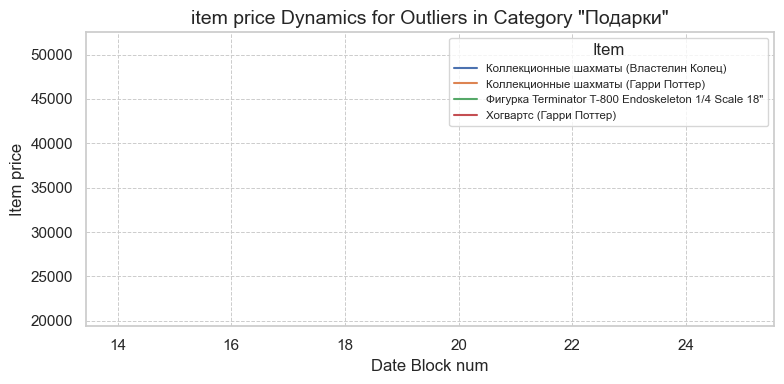

In [542]:
sns.set(style="whitegrid")

gifts_outliers = df_train[(df_train.main_category == 'Подарки') & (df_train.item_price > 20000)]
gifts_outliers = pd.merge(gifts_outliers, df_items, on = 'item_id', how = 'left')
gifts_item_id = list(gifts_outliers.item_id.unique())

pivot_data = pd.pivot_table(df_train[df_train.item_id.isin(gifts_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_price', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Item price', fontsize=12)
plt.title('item price Dynamics for Outliers in Category "Подарки"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

#plt.ylim(0, 15000)

plt.legend(title='Item', loc='upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()

In [543]:
df_train[df_train.item_id.isin(gifts_item_id)]

,item_category_name,item_category_id,main_category,main_category_id,minor_category,minor_category_id,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,shop_name,city,city_id,item_name
1514610,Подарки - Сувениры,69,Подарки,9,Сувениры,58,14,25,13199,1.0,50999.0,3,2014,"Москва ТРК ""Атриум""",Москва,13,Коллекционные шахматы (Властелин Колец)
1517493,Подарки - Сувениры,69,Подарки,9,Сувениры,58,22,12,21483,1.0,21499.0,11,2014,Интернет-магазин ЧС,Интернет-магазин,7,Хогвартс (Гарри Поттер)
1519424,Подарки - Сувениры,69,Подарки,9,Сувениры,58,25,12,13200,1.0,28000.0,2,2015,Интернет-магазин ЧС,Интернет-магазин,7,Коллекционные шахматы (Гарри Поттер)
1555079,Подарки - Фигурки,72,Подарки,9,Фигурки,61,17,25,20842,1.0,20899.0,6,2014,"Москва ТРК ""Атриум""",Москва,13,Фигурка Terminator T-800 Endoskeleton 1/4 Scal...


In [544]:
df_test[df_test.item_id.isin(gifts_item_id)]

,ID,shop_id,item_id


We do not have it in test set, also it contains data only for one sale. It will be reasonable to drop it.

In [545]:
df_train.drop(df_train[(df_train.item_id.isin(gifts_item_id))].index, inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_42256\1195705284.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


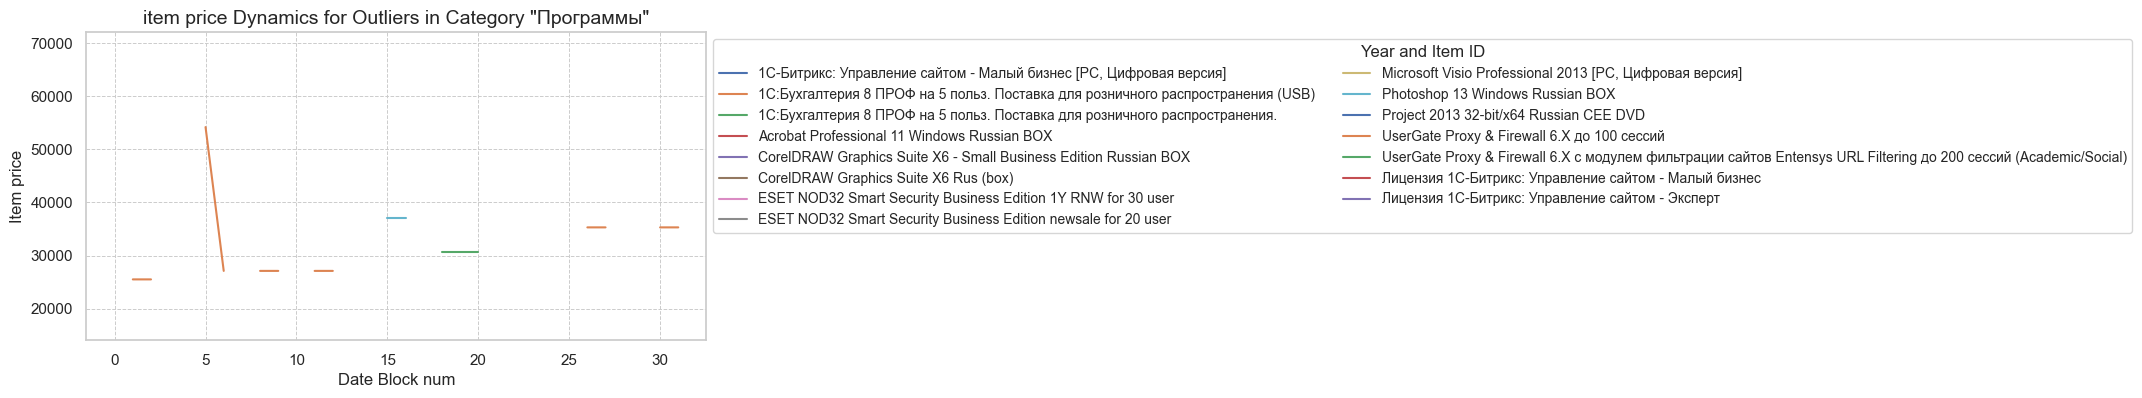

In [546]:
sns.set(style="whitegrid")

programmes_outliers = df_train[(df_train.main_category == 'Программы') & (df_train.item_price > 20000)]
programmes_outliers = pd.merge(programmes_outliers, df_items, on = 'item_id', how = 'left')
programmes_item_id = list(programmes_outliers.item_id.unique())

pivot_data = pd.pivot_table(df_train[df_train.item_id.isin(programmes_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_price', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Item price', fontsize=12)
plt.title('item price Dynamics for Outliers in Category "Программы"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.legend(title='Year and Item ID', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

In [547]:
df_test[df_test.item_id.isin(programmes_item_id)]

,ID,shop_id,item_id


The data for this category with the product price boundary over 20,000 is fragmentary - it will be difficult to make any predictions based on it. The data also includes quite extreme values ​​for item_price. Our prediction set does not include them. Let's delete them.

In [548]:
df_train.drop(df_train[(df_train.item_id.isin(programmes_item_id))].index, inplace = True)

Correlation

In [549]:
df_train = df_train.loc[:, ['item_category_id', 'main_category_id', 'minor_category_id',
       'date_block_num', 'item_id', 'item_cnt_month', 'item_price',
       'month', 'year', 'shop_id', 'city_id']]

In [550]:
categorical = ['date_block_num', 'shop_id', 'item_id', 'item_category_id',
              'main_category_id', 'minor_category_id', 'city_id', 'month', 'year']

numerical = ['item_price']

target = ['item_cnt_month']

In [551]:
columns, correlations = [], []

for col in numerical:
    columns.append(col)
    correlations.append(stats.spearmanr(df_train[col], df_train['item_cnt_month'])[0])

num_corr = pd.DataFrame({'column': columns, 'correlation': correlations})

num_corr.style.background_gradient()

,column,correlation
0,item_price,0.156876


As we could see from graphs, there is no linear correlation between item price and item_cnt_month. Using the Spearman coefficient, we obtained 0.157, which gives us an idea of a small non-linear correlation.

In [552]:
for category in categorical:
    correlation_ratio(df_train['item_cnt_month'], df_train[category], category)

Correlation between sales and date_block_num
Eta_squared: 0.0005
Eta: 0.0234
Correlation between sales and shop_id
Eta_squared: 0.0004
Eta: 0.0197
Correlation between sales and item_id
Eta_squared: 0.0132
Eta: 0.1147
Correlation between sales and item_category_id
Eta_squared: 0.0170
Eta: 0.1306
Correlation between sales and main_category_id
Eta_squared: 0.0277
Eta: 0.1665
Correlation between sales and minor_category_id
Eta_squared: 0.0331
Eta: 0.1819
Correlation between sales and city_id
Eta_squared: 0.0003
Eta: 0.0176
Correlation between sales and month
Eta_squared: 0.0011
Eta: 0.0333
Correlation between sales and year
Eta_squared: 0.0008
Eta: 0.0285


In [553]:
to_csv(df_train, 'data.csv')
to_csv(df_item_categories, 'item_categories.csv')
to_csv(df_shops, 'shops.csv')

Conclusion
Our target is sales per month per shop. Number of sales is influenced by a lot of factors: item price, year, month, category and subcategory of item, shop, city. 
Time (date period, year, month): Most of the sales are time-dependent. In general, we see decrease during all analyzed period of time (we also see this on time-trend during the several years) with presence of seasonality. During the year we see the increase in sales towards the end of the year, that can be associated with holiday’s period. For most of the items we see slight decrease in sales in the middle of the year. According to our data, sales have been declining with each subsequent year.
Item price: There is no linear correlation between item_cnt_month and item price. To get more connection with sales per month, will be reasonable to create new feature – revenue(price*sales).
Category&subcategory: The highest number of sales is in categories such as Games, Movies and Gifts. The lowest sales in the categories of batteries, which may be due to product specificity. The change in sales over the analyzed period for most categories follows a common pattern. However, for the category of books there is a big jump in sales by the end of the period, which is due to the growth of sales in the subcategory of comics, manga. 42% of the subcategories lack data for the full period analyzed. Correlation between target and minor category is a little bit higher, than with main category. By grouping the data into categories, a number of anomalies were discovered in item price and item_cnt_month. 
Shop&city: Sales are vary from shop to shop and it can be due to the size of the shop. Also more sales we see in big cities, and the vast amount of sales we see in the capital – Moscow. Based on the overall graph, the online shop is 15th in terms of sales. However, it can be seen that closer to the end of the analyzed period, unlike offline shops, there is a tendency to increase sales. We have small values for the correlation between item_cnt_month and the City, but this feature provides additional information about shops, for many of which we have insufficient data.